In [42]:
import sys, os, decimal, json
sys.path.append(os.path.realpath('..'))
import json, time
import pandas as pd
import random
import matplotlib.pyplot as plt
import glob

import matplotlib.pyplot as plt
import numpy as np
import PIL, json
import tensorflow as tf
import socket
import pathlib
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageOps

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.metrics import confusion_matrix

from TrainingPipelines.ImageClassifier.ModelBuilder import build_and_train

import seaborn as sns
import mplcyberpunk

plt.style.use("cyberpunk")
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#0d1117'
plt.rcParams['savefig.facecolor'] = '#0d1117'

In [43]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [44]:
def cal_iou(y_true, y_pred):
    x1 = max(y_true[0], y_pred[0])
    y1 = max(y_true[1], y_pred[1])
    x2 = min(y_true[2], y_pred[2])
    y2 = min(y_true[3], y_pred[3])
 
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
 
    true_area = (y_true[2] - y_true[0] + 1) * (y_true[3] - y_true[1] + 1)
    bbox_area = (y_pred[2] - y_pred[0] + 1) * (y_pred[3] - y_pred[1] + 1)
 
    iou = intersection_area / float(true_area + bbox_area - intersection_area)
    return iou

In [45]:
reduction = 4

img_width = int(1920/reduction)
img_height = int(1080/reduction)

In [46]:
image_names = []
path = pathlib.Path('O:\\source\\repos\\data_labeler\\training_data\\\inventory')
for data in glob.glob(f"{path}\*.png"):
    file = data.split('\\')[-1:][0]
    image_names.append(file)

In [47]:
random.shuffle(image_names)

In [48]:
image_data = {}
f = open(f"{path}\\boxes.json")
image_data_raw = json.load(f)
f.close()

for data in image_data_raw:
    image_data[data['image_name']] = data['bbox']
image_data[list(image_data.keys())[0]]

[783, 430, 1333, 725]

In [49]:
for key in image_data:
    if image_data[key][0] > image_data[key][2]:
        print(key)

In [50]:
train_names, val_names, test_names = np.split(image_names, [int(len(image_names)*0.8), int(len(image_names)*0.9)])

In [51]:
train_x = []
for image_name in tqdm(train_names):
    try:
        img = Image.open(f"{path}\\{image_name}")
        if reduction != 1:
            img = img.resize((img_width, img_height), resample=Image.Resampling.LANCZOS)
        train_x.append(np.array(img))
    except:
        print(f"{path}\\{image_name}")
    
val_x = []
for image_name in tqdm(val_names):
    img = Image.open(f"{path}\\{image_name}")
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.LANCZOS)
    val_x.append(np.array(img))
    
test_x = []
for image_name in tqdm(test_names):
    img = Image.open(f"{path}\\{image_name}")
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.LANCZOS)
    test_x.append(np.array(img))
    
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:03<00:00, 26.03it/s]


In [52]:
train_x[0].shape

(270, 480, 3)

In [53]:
train_y = []
for image_name in tqdm(train_names):
    train_y.append(image_data[image_name])
    
val_y = []
for image_name in tqdm(val_names):
    val_y.append(image_data[image_name])
    
test_y = []
for image_name in tqdm(test_names):
    test_y.append(image_data[image_name])

train_y = np.array(train_y) / np.array([1920, 1080, 1920, 1080])
val_y = np.array(val_y) / np.array([1920, 1080, 1920, 1080])
test_y = np.array(test_y) / np.array([1920, 1080, 1920, 1080])

100%|███████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 97076.47it/s]


In [54]:
train_names[0]

'674d07db-cbed-11ed-8167-2cf05d9fe8eb.png'

In [55]:
train_y[0]

array([0.3296875 , 0.15185185, 0.640625  , 0.47407407])

In [56]:
vgg = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
vgg.trainable = False

In [84]:
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    #layers.Resizing(img_height, img_width, interpolation='bilinear', crop_to_aspect_ratio=False),
    #layers.Normalization(input_shape=(img_height, img_width, 3)),
    #vgg,
    #layers.GlobalAveragePooling2D(),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    #layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation="sigmoid")    
])

In [85]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 270, 480, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 268, 478, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 134, 239, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 132, 237, 32)      4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 66, 118, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 116, 64)      

In [86]:
def calculate_iou(y_true, y_pred):
    
    
    """
    Input:
    Keras provides the input as numpy arrays with shape (batch_size, num_columns).
    
    Arguments:
    y_true -- first box, numpy array with format [x, y, width, height, conf_score]
    y_pred -- second box, numpy array with format [x, y, width, height, conf_score]
    x any y are the coordinates of the top left corner of each box.
    
    Output: IoU of type float32. (This is a ratio. Max is 1. Min is 0.)
    
    """

    
    results = []
    
    for i in range(0,y_true.shape[0]):
    
        # set the types so we are sure what type we are using
        y_true = y_true.astype(np.float32)
        y_pred = y_pred.astype(np.float32)


        # boxTrue
        x_boxTrue_tleft = y_true[0,0]  # numpy index selection
        y_boxTrue_tleft = y_true[0,1]
        boxTrue_width = y_true[0,2]
        boxTrue_height = y_true[0,3]
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        x_boxPred_tleft = y_pred[0,0]
        y_boxPred_tleft = y_pred[0,1]
        boxPred_width = y_pred[0,2]
        boxPred_height = y_pred[0,3]
        area_boxPred = (boxPred_width * boxPred_height)


        # calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

        # Calculate the area of boxInt, i.e. the area of the intersection 
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
        
        
        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)


        # This must match the type used in py_func
        iou = iou.astype(np.float32)
        
        # append the result to a list at the end of each loop
        results.append(iou)
    
    # return the mean IoU score for the batch
    return np.mean(results)

In [87]:
def IoU(y_true, y_pred):
    
    # Note: the type float32 is very important. It must be the same type as the output from
    # the python function above or you too may spend many late night hours 
    # trying to debug and almost give up.
    
    iou = tf.numpy_function(calculate_iou, [y_true, y_pred], tf.float32)

    return iou

In [103]:
epochs = 200
lr = 1e-4

callbacks = [
    ReduceLROnPlateau(monitor='val_IoU', factor=0.01, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_IoU', patience=20, restore_best_weights=False),
]

IOUL = tfa.losses.GIoULoss(
    mode='giou',
    reduction=tf.keras.losses.Reduction.AUTO,
    name='giou_loss'
)


model.compile(optimizer=Adam(lr), loss='mse', metrics=['accuracy', 'mse', IoU])

history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=32,
    #shuffle=True,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/200
25/25 [==============================] - 13s 513ms/step - loss: 8.9733e-04 - accuracy: 0.9394 - mse: 8.9733e-04 - IoU: 0.8634 - val_loss: 8.5789e-04 - val_accuracy: 0.8866 - val_mse: 8.5789e-04 - val_IoU: 0.8951 - lr: 1.0000e-04
Epoch 2/200
25/25 [==============================] - 12s 480ms/step - loss: 3.5365e-04 - accuracy: 0.9406 - mse: 3.5365e-04 - IoU: 0.9119 - val_loss: 8.5225e-04 - val_accuracy: 0.8763 - val_mse: 8.5225e-04 - val_IoU: 0.8830 - lr: 1.0000e-04
Epoch 3/200
25/25 [==============================] - 12s 478ms/step - loss: 3.1041e-04 - accuracy: 0.9394 - mse: 3.1041e-04 - IoU: 0.9056 - val_loss: 8.4338e-04 - val_accuracy: 0.8969 - val_mse: 8.4338e-04 - val_IoU: 0.8977 - lr: 1.0000e-04
Epoch 4/200
25/25 [==============================] - 12s 480ms/step - loss: 2.5859e-04 - accuracy: 0.9432 - mse: 2.5859e-04 - IoU: 0.9176 - val_loss: 6.7447e-04 - val_accuracy: 0.8866 - val_mse: 6.7447e-04 - val_IoU: 0.8903 - lr: 1.0000e-04
Epoch 5/200
25/25 [=================

In [104]:
def cell_dims(x1, y1, x2, y2):
    return x1, y1, (x2 - x1) + x1, (y2 - y1) + y1

In [105]:
prediction = model.predict(test_x)
IOUs = []
for i in range(len(test_y)):
    IOUs.append(cal_iou(prediction[i], test_y[i]))
print(f'Average IOU for Test:{sum(IOUs)/len(IOUs)}')

4/4 [==============================] - 0s 127ms/step
Average IOU for Test:0.9532581201083875


In [106]:
calculate_iou(test_y, prediction)

0.94965017

In [107]:
test_y[0]

array([0.4828125 , 0.02592593, 0.99791667, 0.61666667])

In [108]:
prediction[0]

array([0.48414052, 0.02586178, 0.9582951 , 0.6238652 ], dtype=float32)

1/1 [==============================] - 0s 15ms/step
[[ 929.41314697   27.92408109 1839.89135742  673.78296375]]
[ 927.   28. 1916.  666.]
IOU:0.9686956827598946
(929.4131469726562, 27.924081087112427, 1839.891357421875, 673.7829637527466)


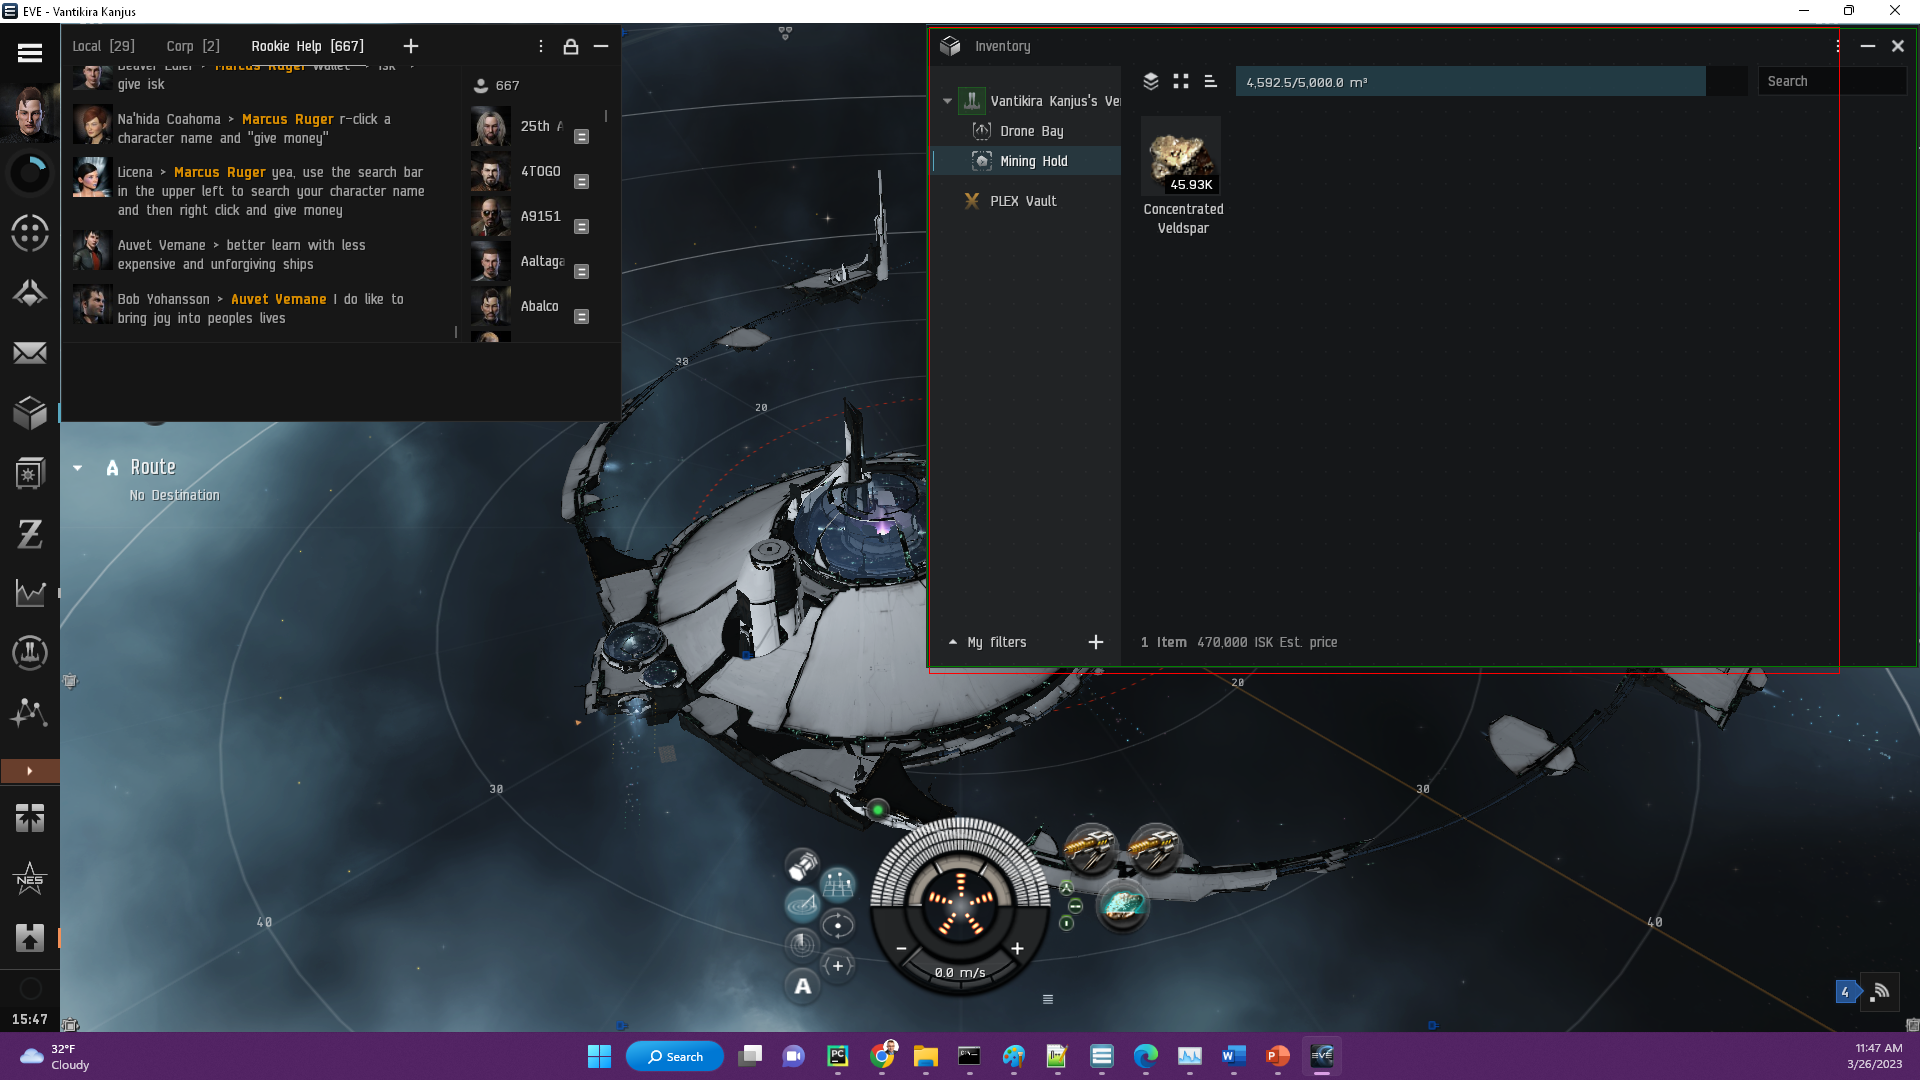

In [109]:
test_image_index = 0

prediction = model.predict(np.array([test_x[test_image_index]]))
result = ((prediction) * np.array([1920, 1080, 1920, 1080])) # reduction
print(result)
truth = (test_y[test_image_index] * np.array([1920, 1080, 1920, 1080])) # reduction
print(truth)

print(f'IOU:{cal_iou(prediction[0], test_y[test_image_index])}')

#mg = Image.fromarray(test_x[test_image_index]) 
img = Image.open(f"{path}\\{test_names[test_image_index]}")
img1 = ImageDraw.Draw(img)  
result2 = cell_dims(*result[0])
print(result2)
img1.rectangle([(result2[0], result2[1]), (result2[2], result2[3])], outline ="red")

result3 = cell_dims(*truth)
img1.rectangle([(result3[0], result3[1]), (result3[2], result3[3])], outline ="Green")


img

In [110]:
model.save('temp.h5')

In [111]:
model2 = tf.keras.models.load_model('temp.h5')
model2.predict(np.array([test_x[test_image_index]]))

TypeError: IoU.__init__() missing 2 required positional arguments: 'num_classes' and 'target_class_ids'